# Demo associative memory through LTP-IE (Figure 4)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport assoc.plot
from copy import deepcopy as copy

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from aux import sgmd
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from assoc import smln, plot

cc = np.concatenate


# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 12000,
    'W_PC_PC': .026, 'L_PC_PC': 0.053, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.005, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 1200,
    'W_INH_PC': 0.003, 'W_PC_INH': 0.00002,
    
    # gating inputs
    'W_PC_G': 0.005, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 200, 
    
    # potentiation
    'SGM_MAX': 1.84, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 4, "BOX_W": 4, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2,
    
    'TRJ': [
        [(-1, 1), (1, -1)],
        [(1, 1), (1.75, 1), (1.75, -1.75), (-1, -1.75), (-1, -1)],
    ],
    
    'TRG': [
        {'T': .25, 'A': 0.005, 'R': 0.1, 'D': 0.002, 'X': -1, 'Y': 1},
        {'T': .75, 'A': 0.005, 'R': 0.1, 'D': 0.002, 'X': -1, 'Y': -1},
        {'T': 1.25, 'A': 0.005, 'R': 0.1, 'D': 0.002, 'X': -1, 'Y': 1},
        {'T': 1.75, 'A': 0.005, 'R': 0.1, 'D': 0.002, 'X': -1, 'Y': -1},
    ],
    
    "schedule": {"D_SMLN": 2.5},
}

In [2]:
def plot_local_pc_fr(rslt, ax, xys, n_nearest, colors, normed=True):
    """Plot avg firing rates of groups of cells w/ PFs w/in radius of specific (x, y) locations."""
    # get PC spks and PFs
    pc_mask = rslt.ntwk.types_rcr == 'PC'
    spks_pc = rslt.spks[:, pc_mask]
    pfxs_pc = rslt.ntwk.pfxs[pc_mask]
    pfys_pc = rslt.ntwk.pfys[pc_mask]

    # get idxs of cells nearest to (x, y) locs
    idxs = plot.get_idxs_nearest_simple(xys, pfxs_pc, pfys_pc, n_nearest)

    # get spks for each loc
    spks_xys = [spks_pc[:, idxs_] for idxs_ in idxs]

    # get FRs
    fr_xys = [np.mean(spks_xy/rslt.s_params['DT'], axis=1) for spks_xy in spks_xys]

    max_frs = [np.max(fr_xy) for fr_xy in fr_xys]
    print('Max FRs: ', max_frs)

    if normed:
        fr_xys = [fr_xy/max_fr for fr_xy, max_fr in zip(fr_xys, max_frs)]
        max_frs = len(fr_xys) * [1]

    # plot FRs
    offset = 0
    offsets = []

    for fr_xy, max_fr, color in zip(fr_xys, max_frs, colors):

        offset -= (1.3 * max_fr)
        offsets.append(offset)

        ax.plot(rslt.ts, fr_xy + offset, lw=2, color=color)
        ax.axhline(offset, color='gray', alpha=.5, ls='--')
        ax.axhline(offset + max_fr, color='gray', alpha=.5, ls='--')

    ax.set_yticks([])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized\nReadout Response')
    
    return ax

# Run smlns

# LTP-IE profile 1

In [3]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['TRJ'] = [
    [(-1, 1), (1, 1)],
    [(-1, -1), (1, -1)],
]

s_params['RNG_SEED'] = 0


try:
    rslt = np.load('assoc/rslt_1a.npy')[0]['rslt']
except:
    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    np.save('assoc/rslt_1a.npy', np.array([{'rslt': rslt}]))
    print('Smln complete.')

Max FRs:  [560.0, 560.0, 160.0, 200.0]


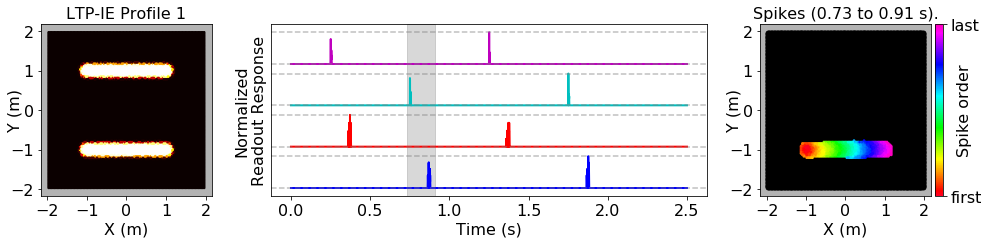

In [4]:
# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.23, .41), (.73, .91), (1.23, 1.41), (1.73, 1.91)]

gs = gridspec.GridSpec(1, 4)

fig = plt.figure(figsize=(14, 14/4), tight_layout=True)
axs = []
axs.append(fig.add_subplot(gs[0, :1]))
axs.append(fig.add_subplot(gs[0, 1:3]))
axs.append(fig.add_subplot(gs[0, 3]))

plot.ltp_ie_profile(rslt, axs[0], sct_sz=3)
plot_local_pc_fr(rslt, axs[1], xys=[(-1, 1), (-1, -1), (1, 1), (1, -1)], n_nearest=50, colors=['m', 'c', 'r', 'b'])
c_ax = plot.spike_seq(rslt, axs[2], fig, epoch=EPOCHS[1], sct_sz=3)[1]

axs[0].set_title('LTP-IE Profile 1')

axs[1].axvspan(*EPOCHS[1], color='gray', alpha=0.3)

for ax in axs + [c_ax]:
    set_font_size(ax, 16)

# LTP-IE profile 2A

In [5]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['TRJ'] = [
    [(-1, 1), (1, -1)],
    [(1, 1), (1.75, 1), (1.75, -1.75), (-1, -1.75), (-1, -1)],
]
s_params['RNG_SEED'] = 0

try:
    rslt = np.load('assoc/rslt_2a.npy')[0]['rslt']
except:
    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    np.save('assoc/rslt_2a.npy', np.array([{'rslt': rslt}]))
    print('Smln complete.')

Max FRs:  [520.0, 560.0, 160.0, 120.0]


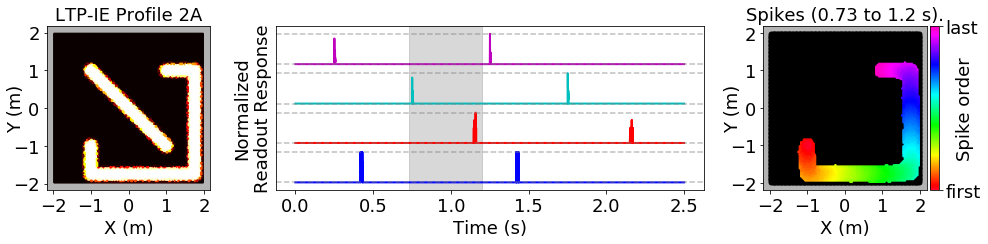

In [6]:
# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.23, .47), (.73, 1.2), (1.23, 1.47), (1.73, 2.2)]

gs = gridspec.GridSpec(1, 4)

fig = plt.figure(figsize=(14, 14/4), tight_layout=True)
axs = []
axs.append(fig.add_subplot(gs[0, :1]))
axs.append(fig.add_subplot(gs[0, 1:3]))
axs.append(fig.add_subplot(gs[0, 3]))

plot.ltp_ie_profile(rslt, axs[0], sct_sz=3)
plot_local_pc_fr(rslt, axs[1], xys=[(-1, 1), (-1, -1), (1, 1), (1, -1)], n_nearest=50, colors=['m', 'c', 'r', 'b'])
c_ax = plot.spike_seq(rslt, axs[2], fig, epoch=EPOCHS[1], sct_sz=3)[1]

axs[0].set_title('LTP-IE Profile 2A')

axs[1].axvspan(*EPOCHS[1], color='gray', alpha=0.3)

for ax in axs + [c_ax]:
    set_font_size(ax, 18)

# LTP-IE profile 2B

In [7]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['TRJ'] = [
    [(-1, 1), (1, -1)],
    [(1, 1), (1, 1.75), (-1.75, 1.75), (-1.75, -1), (-1, -1)],
]

s_params['RNG_SEED'] = 0

try:
    rslt = np.load('assoc/rslt_2b.npy')[0]['rslt']
except:
    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    np.save('assoc/rslt_2b.npy', np.array([{'rslt': rslt}]))
    print('Smln complete.')

Max FRs:  [520.0, 560.0, 120.0, 120.0]


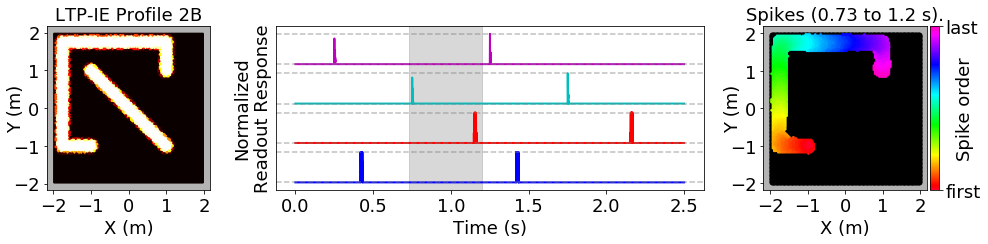

In [8]:
# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.23, .47), (.73, 1.2), (1.23, 1.47), (1.73, 2.2)]

gs = gridspec.GridSpec(1, 4)

fig = plt.figure(figsize=(14, 14/4), tight_layout=True)
axs = []
axs.append(fig.add_subplot(gs[0, :1]))
axs.append(fig.add_subplot(gs[0, 1:3]))
axs.append(fig.add_subplot(gs[0, 3]))

plot.ltp_ie_profile(rslt, axs[0], sct_sz=3)
plot_local_pc_fr(rslt, axs[1], xys=[(-1, 1), (-1, -1), (1, 1), (1, -1)], n_nearest=50, colors=['m', 'c', 'r', 'b'])
c_ax = plot.spike_seq(rslt, axs[2], fig, epoch=EPOCHS[1], sct_sz=3)[1]

axs[0].set_title('LTP-IE Profile 2B')

axs[1].axvspan(*EPOCHS[1], color='gray', alpha=0.3)

for ax in axs + [c_ax]:
    set_font_size(ax, 18)

# LTP-IE profile 2C

In [9]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['TRJ'] = [
    [(-1, -1), (1, 1)],
    [(-1, 1), (-1, 1.75), (1.75, 1.75), (1.75, -1), (1, -1)],
]

s_params['RNG_SEED'] = 0

try:
    rslt = np.load('assoc/rslt_2c.npy')[0]['rslt']
except:
    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    np.save('assoc/rslt_2c.npy', np.array([{'rslt': rslt}]))
    print('Smln complete.')

Max FRs:  [560.0, 560.0, 200.0, 120.0]


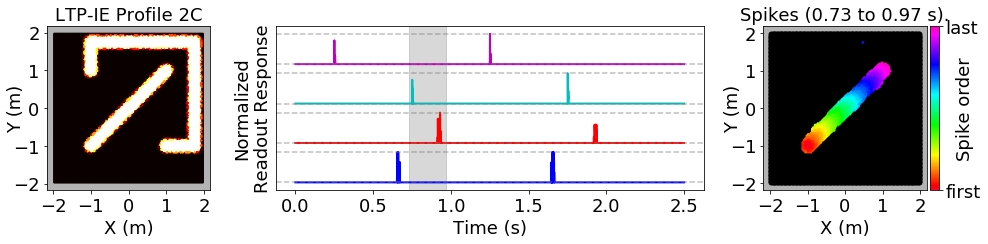

In [10]:
# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.23, .7), (.73, .97), (1.23, 1.7), (1.73, 1.97)]

gs = gridspec.GridSpec(1, 4)

fig = plt.figure(figsize=(14, 14/4), tight_layout=True)
axs = []
axs.append(fig.add_subplot(gs[0, :1]))
axs.append(fig.add_subplot(gs[0, 1:3]))
axs.append(fig.add_subplot(gs[0, 3]))

plot.ltp_ie_profile(rslt, axs[0], sct_sz=3)
plot_local_pc_fr(rslt, axs[1], xys=[(-1, 1), (-1, -1), (1, 1), (1, -1)], n_nearest=50, colors=['m', 'c', 'r', 'b'])
c_ax = plot.spike_seq(rslt, axs[2], fig, epoch=EPOCHS[1], sct_sz=3)[1]

axs[0].set_title('LTP-IE Profile 2C')

axs[1].axvspan(*EPOCHS[1], color='gray', alpha=0.3)

for ax in axs + [c_ax]:
    set_font_size(ax, 18)

# Demo network with no spontaneous but successful triggered replay
## (For auxiliary purposes; no manuscript figures below)

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport replay.plot
%aimport replay.analysis
from copy import deepcopy as copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from aux import sgmd
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from assoc import smln, plot

cc = np.concatenate


# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 3000,
    'W_PC_PC': .026, 'L_PC_PC': 0.053, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.005, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 300,  # unused
    'W_INH_PC': 0.003, 'W_PC_INH': 0.0002,
    
    # gating inputs
    'W_PC_G': 0.005, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 200, 
    
    # potentiation
    'SGM_MAX': 1.84, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [[(-1, .75), (0, .75), (0, -.75), (1, -.75)]],
    
    'TRG': [
        {'T': .5, 'A': 0.01, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
        {'T': 1.5, 'A': 0.01, 'R': 0.3, 'D': 0.002, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": 2},
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 0

print('Running smln...')
rslt = smln.run(m_params, s_params)
print('Smln complete.')

Running smln...
Smln complete.


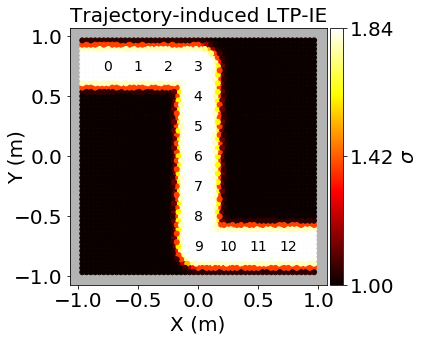

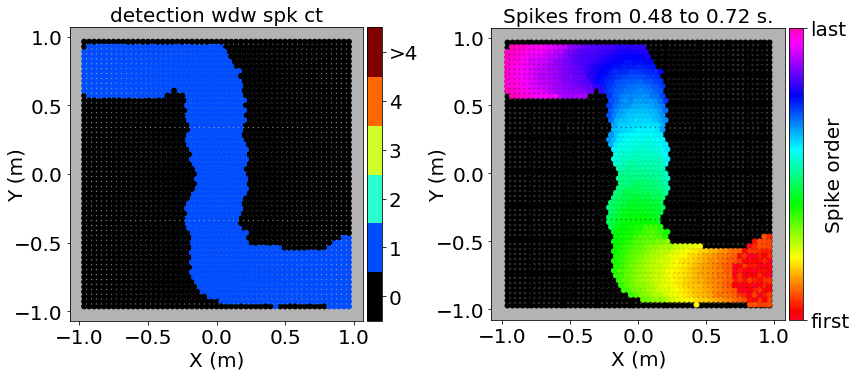

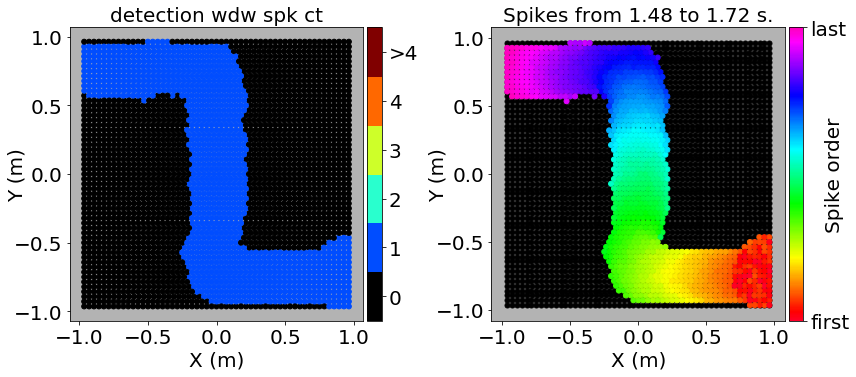

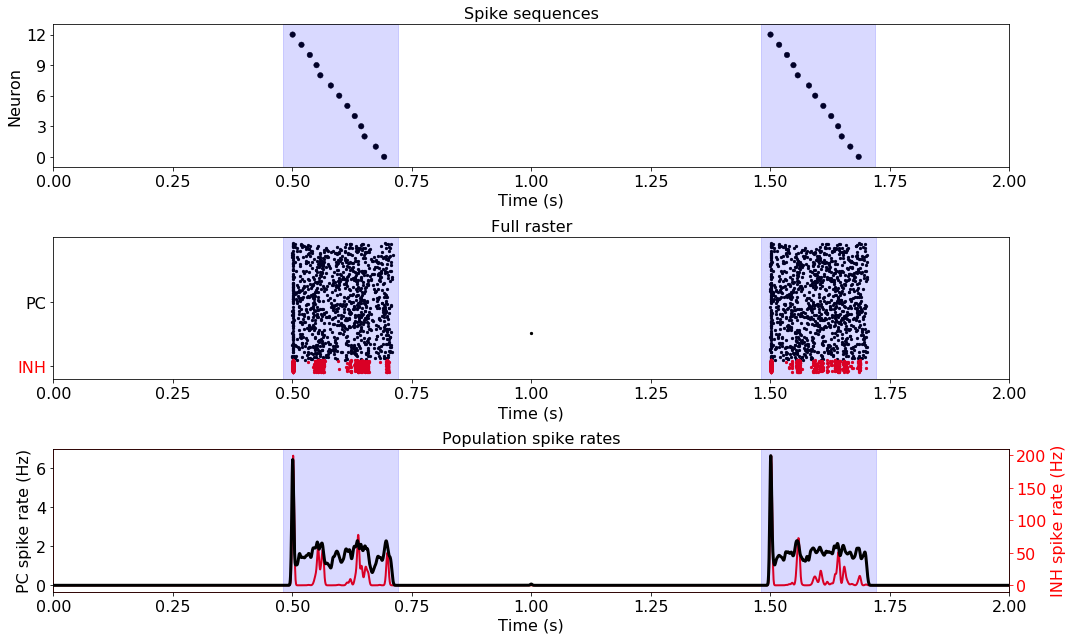

In [13]:
from replay import plot

# make plots
XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]
EPOCHS = [(.48, .72), (1.48, 1.72)]

## potentiation profile
ax, c_ax = plot.ltp_ie_profile(rslt)

## add PC labels
for ctr, (x, y) in enumerate(XYS_RASTER):
    ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot.spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot.raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 2),
    trg_plt=[],
    y_lim=(-1, 13),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)